# Elastic Net Models

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


## Loading Data
First load all the gene expressions and the top 1000 genes whose ratios of between age variance and within age variance are the largest.

In [2]:
geneexp = pd.read_csv("gene_expression_original.csv", sep='\t', index_col=0)

In [4]:
selected_genes = pd.read_csv("enet/topgenes.tsv", sep='\t', index_col=0)
top_genes = selected_genes.index.tolist()
selected_geneexp_mat = np.array(geneexp.loc[top_genes, :]).transpose()
log_geneexp_mat = np.log(selected_geneexp_mat)

In [11]:
import re
# extract the month numbers
def extract_number(mystring):
    numbers = re.findall("^\d+", mystring)
    return int(numbers[0])
# get the ages
ages = np.array([extract_number(timestring) for timestring in geneexp.columns.tolist()]).reshape(-1, 1)

## Elastic Net Regression
When fitting elastic net regressions, I tune two hyperparameters. The first is the number of genes included in the model (50, 100, 200, 300, 400, 500). The other is the regularization parameter. The parameter that decides the proportion of l1 penalty and l2 penalty is fixed at 0.5.

When evaluating the performance of elastic net at different combinations of hyperparameters, I adopt two schemes: Leave one sample out evaluation (LOSO) and leave one age out (LOAO) evaluation. LOSO means fitting elastic net on 49 samples and evaluate the mean absolute error for the left-out sample. LOAO means leaving out all the samples from one age and use the rest of the samples to fit the elastic net regression. Besides mean square error, The stability of each feature being selected into the model is also worth evaluating.

In [7]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

In [8]:
num_features = np.array([50, 100, 200, 300, 400, 500])
penalties = 0.05*(2**np.arange(0, 6))
l1ratios = 0.5
# each entry in the dictionary is a matrix of values
loso_mae = pd.DataFrame(np.zeros((len(num_features), len(penalties))),
                        index=num_features.astype(str),
                        columns=penalties.astype(str)) # leave one sample out MAE
loso_instability = pd.DataFrame(np.zeros((len(num_features), len(penalties))),
                        index=num_features.astype(str),
                        columns=penalties.astype(str)) # leave one sample out instability
loao_mae = pd.DataFrame(np.zeros((len(num_features), len(penalties))),
                        index=num_features.astype(str),
                        columns=penalties.astype(str)) # leave one age out MAE
loao_instability = pd.DataFrame(np.zeros((len(num_features), len(penalties))),
                        index=num_features.astype(str),
                        columns=penalties.astype(str)) # leave one age out instability
# optimal_param = {num_feature: [] for num_feature in num_features}



In [51]:
def enet_fit(X, Y, nfeature=50, penalty=0.2, l1ratio=0.5, folds = None, detail=False):
    """
    :param X: predictor matrix, nsample * ngene
    :param Y: age to be predicted, nsamples
    :param nfeature: number of top features in X to be preserved
    :param penalty: penalty parameter
    :param l1ratio: proportion of L1 penalty
    :param folds: a list of indices
    :detail: return the details of analysis
    :return: mean absolute error and instability statistics
    """
    X_subset = X[:, 0:nfeature]
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(alpha=penalty,l1_ratio=l1ratio,max_iter=20000))
    ])
    error = np.zeros(X_subset.shape[0])
    if folds is None: #loso
        folds = np.arange(0, X.shape[0])
    coefficients = np.zeros((len(folds), nfeature))

    for j, fold in enumerate(folds):

        X_train = np.delete(X_subset, fold, axis=0)
        Y_train = np.delete(Y, fold, axis=0)
        X_test = X_subset[fold, :].reshape(-1, nfeature)
        Y_test = Y[fold]
        model.fit(X_train, Y_train)
        coefficients[j, :] = model['elasticnet'].coef_
        y_test_pred = model.predict(X_test)
        # print(y_test_pred)
        # print(Y_test)
        error[fold] = y_test_pred - Y_test.flatten()

    mae = np.mean(np.abs(error))
    selection_prob = np.mean(coefficients !=0, axis=0)
    instability = np.mean(selection_prob * (1-selection_prob))

    if detail:
        return error, coefficients
    else:
        return mae, instability


First report performance when each sample is left out one by one.

In [14]:
for i, num_feature in enumerate(num_features):
    print(num_feature)
    for j, penalty in enumerate(penalties):
        mae, instability = enet_fit(X=log_geneexp_mat, Y=ages, nfeature=num_feature,
                                    penalty=penalty, l1ratio=0.5)
        loso_mae.iloc[i, j] = mae
        loso_instability.iloc[i, j] = instability

50
100
200
300
400
500


Then report performance when samples from each age are left out one by one.

In [17]:
unique_ages = np.unique(ages)
age_folds = [np.where(ages == age)[0] for age in unique_ages]

I also check the performance when samples of a specific age are taken altogether as the test set.

In [18]:
for i, num_feature in enumerate(num_features):
    print(num_feature)
    for j, penalty in enumerate(penalties):
        mae, instability = enet_fit(X=log_geneexp_mat, Y=ages, nfeature=num_feature,
                                    penalty=penalty, l1ratio=0.5, folds=age_folds)
        loao_mae.iloc[i, j] = mae
        loao_instability.iloc[i, j] = instability

50
100
200
300
400
500


In [21]:
loso_mae.to_csv("enet/loso_mae.tsv", sep='\t')
loso_instability.to_csv("enet/loso_instability.tsv", sep='\t')
loao_mae.to_csv("enet/loao_mae.tsv, sep='\t")
loao_instability.to_csv("enet/loao_instability.tsv", sep='\t')

## Visualize and Summary
First pick the best combination of hyperparameters. Visulize the MAE and the instability.

In [22]:
color_gray="#808080"
color_red="#db382c"
color_green="#2f7028"
color_brown="#665223"
color_blue="#344885"
color_magenta="#b538b3"
all_colors = [color_gray, color_red, color_green, color_brown, color_blue, color_magenta]

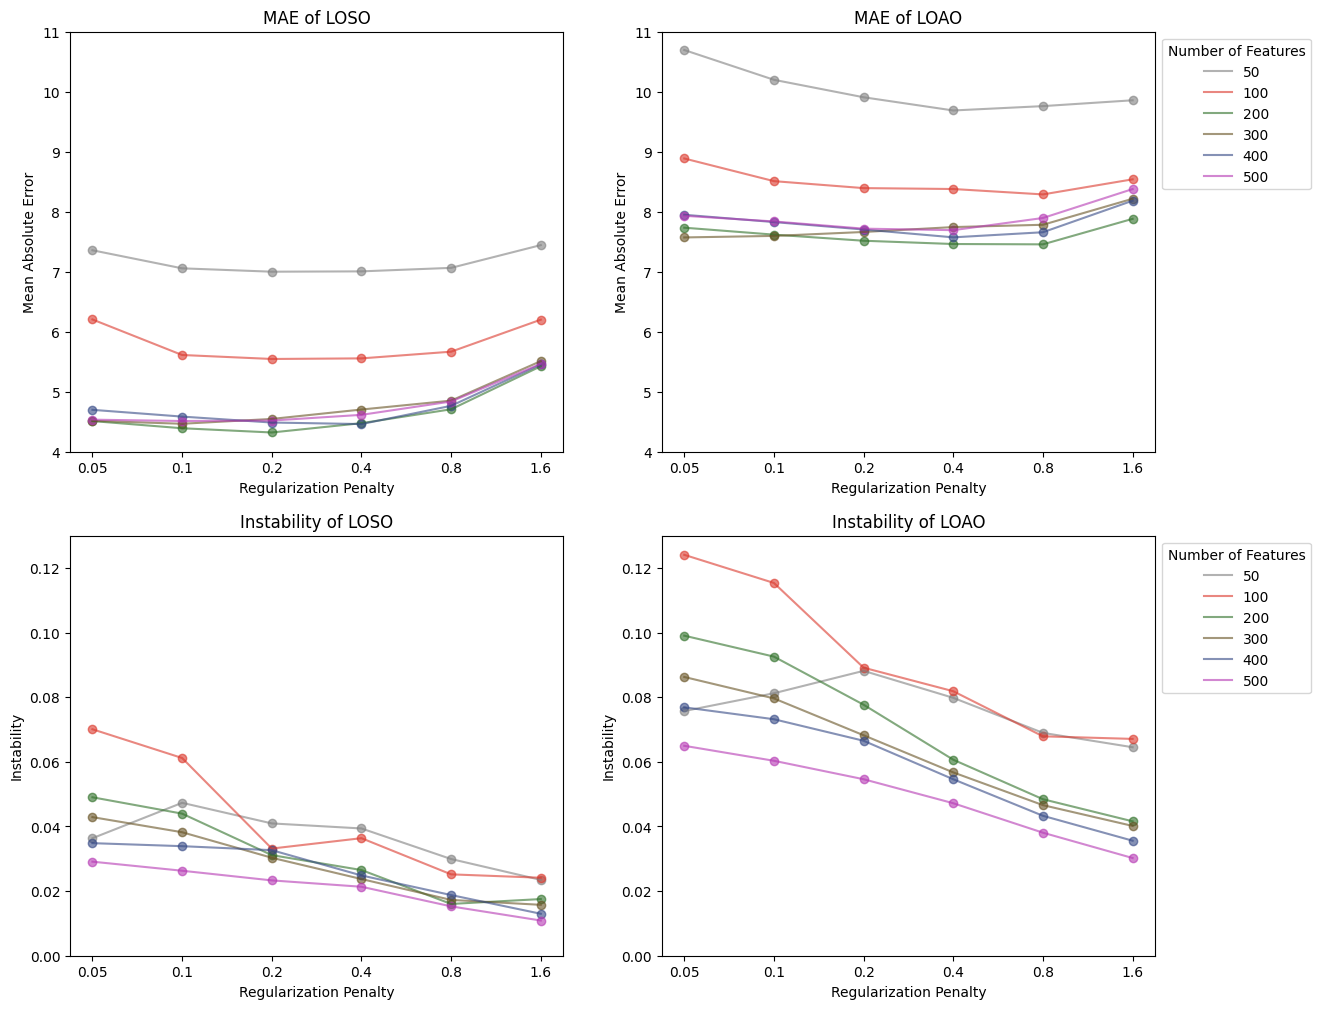

In [43]:
import matplotlib.pyplot as plt
fig1, ax1=plt.subplots(figsize=(14, 12), nrows=2, ncols=2)
xvals = np.arange(1, len(penalties)+1)

## MAE of LOSO
for i, num_feature in enumerate(num_features):
    mae = loso_mae.iloc[i, :].to_numpy()
    ax1[0,0].plot(xvals, mae, label=str(num_feature), color=all_colors[i], alpha=0.6)
    ax1[0,0].scatter(xvals, mae, color=all_colors[i], alpha=0.6)
ax1[0,0].set_xlabel('Regularization Penalty')
ax1[0,0].set_xticks(xvals, labels=penalties.astype(str))
ax1[0,0].set_ylabel("Mean Absolute Error")
ax1[0,0].set_title("MAE of LOSO")
ax1[0,0].set_ylim(4, 11)
# ax1[0,0].legend(title="Number of Features", loc="upper left", bbox_to_anchor=(1,1))

## MAE of LOSO
for i, num_feature in enumerate(num_features):
    mae = loao_mae.iloc[i, :].to_numpy()
    ax1[0,1].plot(xvals, mae, label=str(num_feature), color=all_colors[i], alpha=0.6)
    ax1[0,1].scatter(xvals, mae, color=all_colors[i], alpha=0.6)
ax1[0,1].set_xlabel('Regularization Penalty')
ax1[0,1].set_xticks(xvals, labels=penalties.astype(str))
ax1[0,1].set_ylabel("Mean Absolute Error")
ax1[0,1].set_title("MAE of LOAO")
ax1[0,1].set_ylim(4, 11)
ax1[0,1].legend(title="Number of Features", loc="upper left", bbox_to_anchor=(1,1))


## Instability of LOSO
for i, num_feature in enumerate(num_features):
    instability = loso_instability.iloc[i, :].to_numpy()
    ax1[1,0].plot(xvals, instability, label=str(num_feature), color=all_colors[i], alpha=0.6)
    ax1[1,0].scatter(xvals, instability, color=all_colors[i], alpha=0.6)
ax1[1,0].set_xlabel('Regularization Penalty')
ax1[1,0].set_xticks(xvals, labels=penalties.astype(str))
ax1[1,0].set_ylabel("Instability")
ax1[1,0].set_title("Instability of LOSO")
ax1[1,0].set_ylim(0, 0.13)
# ax1[1,0].legend(title="Number of Features", loc="upper left", bbox_to_anchor=(1,1))


## Instability of LOAO
for i, num_feature in enumerate(num_features):
    instability = loao_instability.iloc[i, :].to_numpy()
    ax1[1,1].plot(xvals, instability, label=str(num_feature), color=all_colors[i], alpha=0.6)
    ax1[1,1].scatter(xvals, instability, color=all_colors[i], alpha=0.6)
ax1[1,1].set_xlabel('Regularization Penalty')
ax1[1,1].set_xticks(xvals, labels=penalties.astype(str))
ax1[1,1].set_ylabel("Instability")
ax1[1,1].set_title("Instability of LOAO")
ax1[1,1].set_ylim(0, 0.13)
ax1[1,1].legend(title="Number of Features", loc="upper left", bbox_to_anchor=(1,1))


fig1.savefig("enet/elastic_net_tune.png", bbox_inches='tight', dpi=400)

I decide that a shrinkage parameter of 0.4 and starting from 200 genes can achieve the best performance. Take a closer look at the prediction error.

In [55]:
loso_pred_error, loso_coefficients = enet_fit(X=log_geneexp_mat, Y=ages, nfeature=200, penalty=0.4, detail=True)
loso_pred = ages.flatten() + loso_pred_error

loao_pred_error, loao_coefficients = enet_fit(X=log_geneexp_mat, Y=ages, nfeature=200, penalty=0.4, folds=age_folds,  detail=True)
loao_pred = ages.flatten() + loao_pred_error

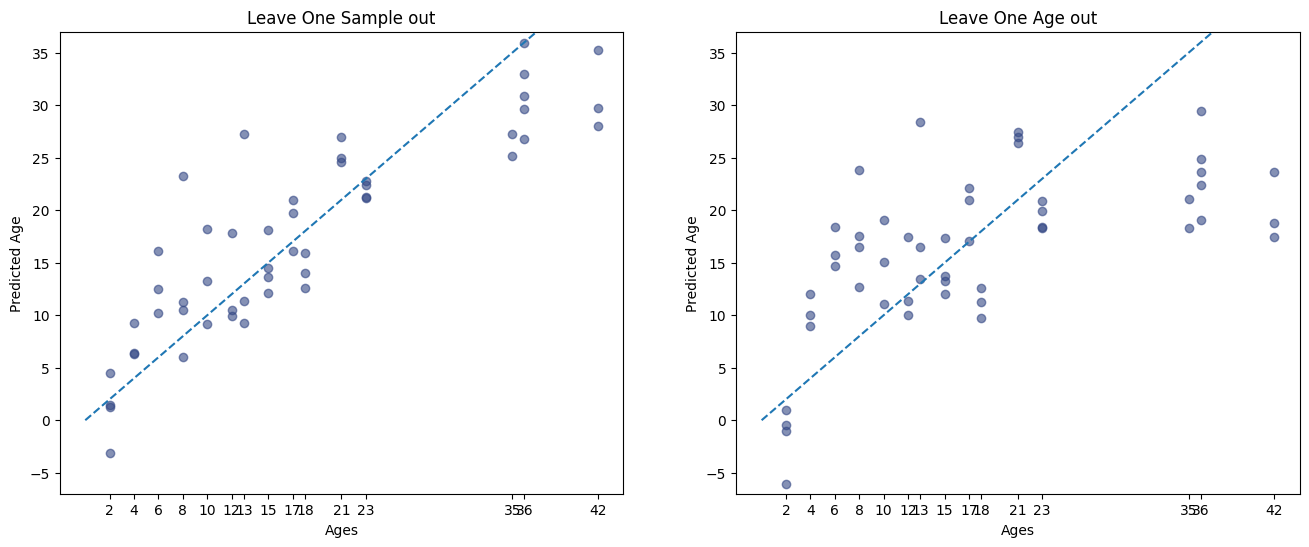

In [71]:
# plot both loso and loao error
# add diagonal line
fig2, ax2 = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

ax2[0].scatter(ages, loso_pred, color=color_blue, alpha=0.6)
ax2[0].set_xlabel('Ages')
ax2[0].set_xticks(np.unique(ages))
ax2[0].set_ylabel("Predicted Age")
ax2[0].set_title("Leave One Sample out")
ax2[0].set_ylim(-7, 37)
ax2[0].plot([0,37], [0, 37], linestyle='--')

ax2[1].scatter(ages, loao_pred, color=color_blue, alpha=0.6)
ax2[1].set_xlabel('Ages')
ax2[1].set_xticks(np.unique(ages))
ax2[1].set_ylabel("Predicted Age")
ax2[1].set_title("Leave One Age out")
ax2[1].set_ylim(-7, 37)
ax2[1].plot([0,37], [0, 37], linestyle='--')

fig2.savefig("enet/fitted_points.png", bbox_inches='tight', dpi=400)


Plot the selection frequency of the 200 genes.

In [95]:
loso_frequency = np.sum(loso_coefficients !=0, axis=0)
loso_frequency_condensed = [np.sum(np.logical_and(loso_frequency > j*5, loso_frequency <=(j+1)*5)) for j in range(10)]
loso_frequency_condensed.insert(0, np.sum(loso_frequency == 0))
loso_categories = ["0"] + [f'{j*5+1}-{(j+1)*5}' for j in range(10)]

In [96]:
loao_frequency = np.sum(loao_coefficients !=0, axis=0)
loao_frequency_condensed = [np.sum(np.logical_and(loao_frequency > j*3, loao_frequency <=(j+1)*3)) for j in range(5)]
loao_frequency_condensed.insert(0, np.sum(loao_frequency == 0))
loao_categories = ["0"] + [f'{j*3+1}-{(j+1)*3}' for j in range(5)]

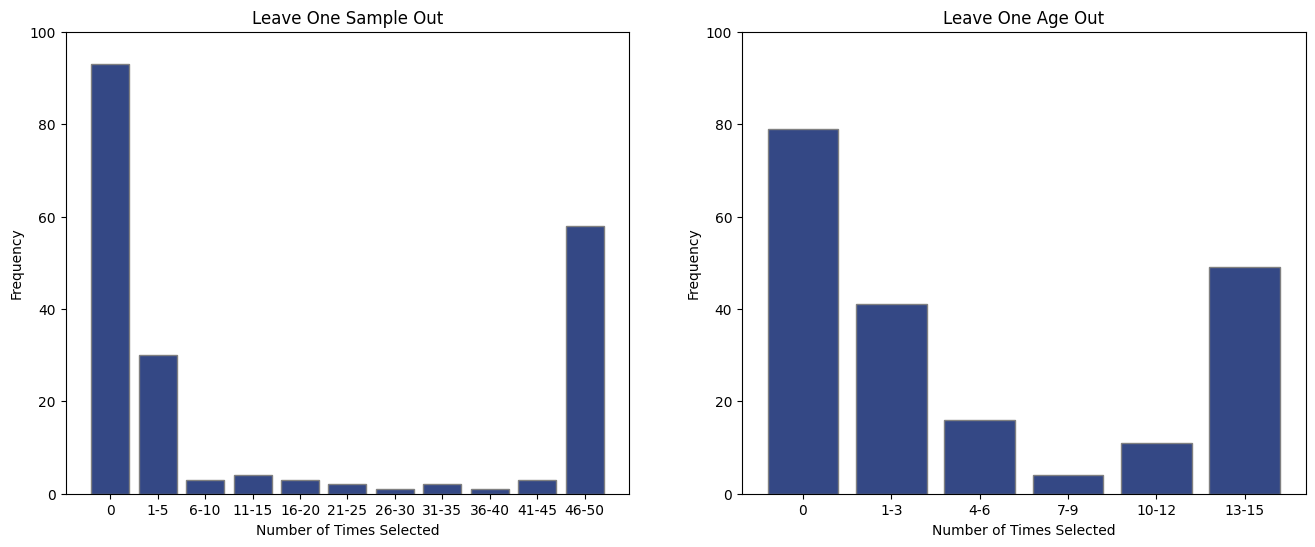

In [100]:
fig3, ax3=plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
ax3[0].bar(loso_categories, loso_frequency_condensed, color=color_blue, edgecolor=color_gray)
ax3[0].set_xlabel("Number of Times Selected")
ax3[0].set_ylabel("Frequency")
ax3[0].set_title("Leave One Sample Out")
ax3[0].set_ylim(0, 100)

ax3[1].bar(loao_categories, loao_frequency_condensed, color=color_blue, edgecolor=color_gray)
ax3[1].set_xlabel("Number of Times Selected")
ax3[1].set_ylabel("Frequency")
ax3[1].set_title("Leave One Age Out")
ax3[1].set_ylim(0, 100)

fig3.savefig("enet/Selection_Frequency.png", bbox_inches='tight', dpi=400)


In [113]:
candidates_1 = set(np.where(loso_frequency >= 49)[0])
candidates_2 = set(np.where(loao_frequency >= 14)[0])
selected_candidates = list(candidates_1.intersection(candidates_2))

In [143]:
predictive_genes = np.array(top_genes)[np.array(selected_candidates)]
with open('enet/predictive_genes.txt', 'w') as f:
    for gene in predictive_genes:
        f.write(f'{gene}\n')

In [135]:
unique_ages = np.unique(ages).flatten()
xvals=np.arange(len(unique_ages))
for id in selected_candidates:
    gene_name = top_genes[id]
    logTPM = log_geneexp_mat[:, id]
    log_TPM_df = pd.DataFrame({'LogTPM': logTPM, 'Age': ages.flatten()})
    mean_logTPM = log_TPM_df.groupby('Age')['LogTPM'].mean().to_numpy()
    sd_logTPM = log_TPM_df.groupby('Age')['LogTPM'].std().to_numpy()
    fig4, ax4 = plt.subplots(figsize=(6, 4))
    ax4.errorbar(xvals, mean_logTPM, yerr=sd_logTPM, fmt='-o', color=color_blue, capsize=5, alpha=0.7)
    ax4.set_xticks(xvals, labels=np.unique(ages))
    ax4.set_xlabel("Month")
    ax4.set_ylabel("Log TPM")
    ax4.set_title(gene_name)
    filename= f'enet/selected_genes/{gene_name}.png'
    fig4.savefig(filename, bbox_inches='tight', dpi=400)
    plt.close(fig4)